In [30]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
from datetime import datetime

covid_data = pd.read_csv('../input/covid19-dataset/owid-covid-data.csv')
#we only want data from India
#and we only want 2 columns, date,new_cases
covid_data = covid_data[covid_data['location']=='India'][['date','new_cases']]
print(covid_data)
#we replace NaN with 0 in cases and deaths
covid_data.update(covid_data[['new_cases']].fillna(0))
#No more missing values
#now use date as indexs
covid_data['date'] = pd.to_datetime(covid_data.date,format='%Y-%m-%d')
covid_data.index = covid_data['date']
covid_data=covid_data.drop('date', axis=1)
print(covid_data)




             date  new_cases
69678  2020-01-30        1.0
69679  2020-01-31        0.0
69680  2020-02-01        0.0
69681  2020-02-02        1.0
69682  2020-02-03        1.0
...           ...        ...
70439  2022-03-01     7554.0
70440  2022-03-02     6561.0
70441  2022-03-03     6396.0
70442  2022-03-04     5921.0
70443  2022-03-05     5476.0

[766 rows x 2 columns]
            new_cases
date                 
2020-01-30        1.0
2020-01-31        0.0
2020-02-01        0.0
2020-02-02        1.0
2020-02-03        1.0
...               ...
2022-03-01     7554.0
2022-03-02     6561.0
2022-03-03     6396.0
2022-03-04     5921.0
2022-03-05     5476.0

[766 rows x 1 columns]


Text(0.5, 1.0, 'New Cases vs Date')

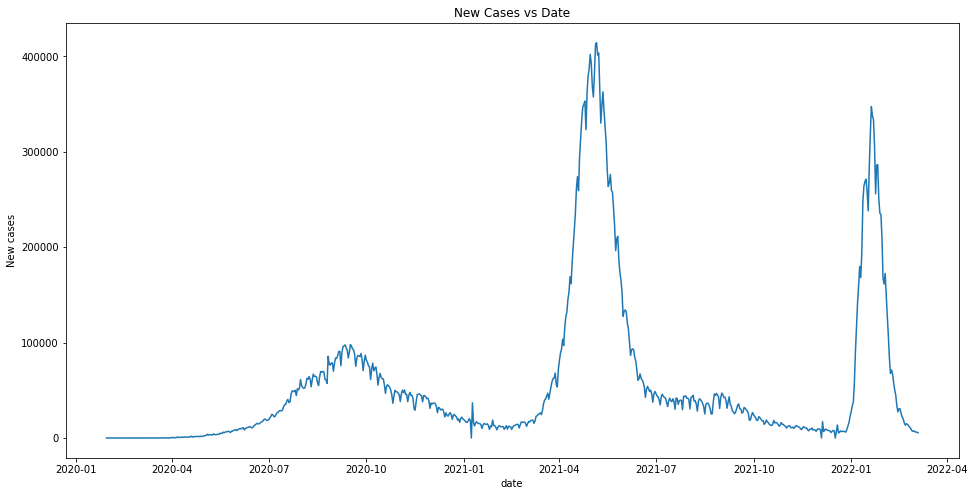

In [31]:


#plt.plot(covid_data['total_cases'], label='Total Cases')

plt.rcParams["figure.figsize"] = (16,8)
plt.plot(covid_data['new_cases'])
plt.xlabel("date")
plt.ylabel('New cases')
plt.title('New Cases vs Date')


In [32]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy
from sklearn.metrics import r2_score


In [33]:
scaler = MinMaxScaler()
look_back=1
df = covid_data['new_cases'].values.reshape(-1,1)
df[0:10]

array([[1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [34]:
# split into train and test sets
train_size = int(len(df) * 0.7)
test_size = len(df) - train_size
train, test = df[0:train_size,:], df[train_size:len(df),:]
#scale after train-test split to avoid information leak from test
train = scaler.fit_transform(train)
test = scaler.transform(test)
df= scaler.transform(df)
print(len(train), len(test))

536 230


In [35]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [36]:
x_train, y_train = create_dataset(train, look_back=1)
x_test, y_test = create_dataset(test, look_back=1)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(x_train[0:10])
print(y_train[0:10])

(534, 1)
(534,)
(228, 1)
(228,)
[[2.41436256e-06]
 [0.00000000e+00]
 [0.00000000e+00]
 [2.41436256e-06]
 [2.41436256e-06]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]]
[0.00000000e+00 0.00000000e+00 2.41436256e-06 2.41436256e-06
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]


In [37]:
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)


(534, 1, 1)
(534,)
(228, 1, 1)
(228,)


In [38]:
model = Sequential()
#units = 4,  batch_size=1, timesteps = 1, features = 1
model.add(LSTM(4,batch_input_shape=(1, x_train.shape[1], x_train.shape[2]),return_sequences=True))
model.add(LSTM(1))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()
#output (1,1,4) = (batch_size, timesteps, unit)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (1, 1, 4)                 96        
_________________________________________________________________
lstm_5 (LSTM)                (1, 1)                    24        
_________________________________________________________________
dense_2 (Dense)              (1, 1)                    2         
Total params: 122
Trainable params: 122
Non-trainable params: 0
_________________________________________________________________


In [39]:
model.fit(x_train, y_train, epochs=16, batch_size=1, verbose=2)

Epoch 1/16
534/534 - 4s - loss: 0.0422
Epoch 2/16
534/534 - 1s - loss: 0.0362
Epoch 3/16
534/534 - 1s - loss: 0.0222
Epoch 4/16
534/534 - 1s - loss: 0.0061
Epoch 5/16
534/534 - 1s - loss: 0.0011
Epoch 6/16
534/534 - 1s - loss: 6.2296e-04
Epoch 7/16
534/534 - 1s - loss: 6.1260e-04
Epoch 8/16
534/534 - 1s - loss: 6.0048e-04
Epoch 9/16
534/534 - 1s - loss: 5.9695e-04
Epoch 10/16
534/534 - 1s - loss: 5.7821e-04
Epoch 11/16
534/534 - 1s - loss: 5.7175e-04
Epoch 12/16
534/534 - 1s - loss: 5.8564e-04
Epoch 13/16
534/534 - 1s - loss: 5.9998e-04
Epoch 14/16
534/534 - 1s - loss: 5.4954e-04
Epoch 15/16
534/534 - 1s - loss: 5.4808e-04
Epoch 16/16
534/534 - 1s - loss: 5.4558e-04


In [40]:
trainPredict = model.predict(x_train,batch_size=1)
testPredict = model.predict(x_test,batch_size=1)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([y_test])
# calculate root mean squared error
trainScore = sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 9559.35 RMSE
Test Score: 11753.16 RMSE


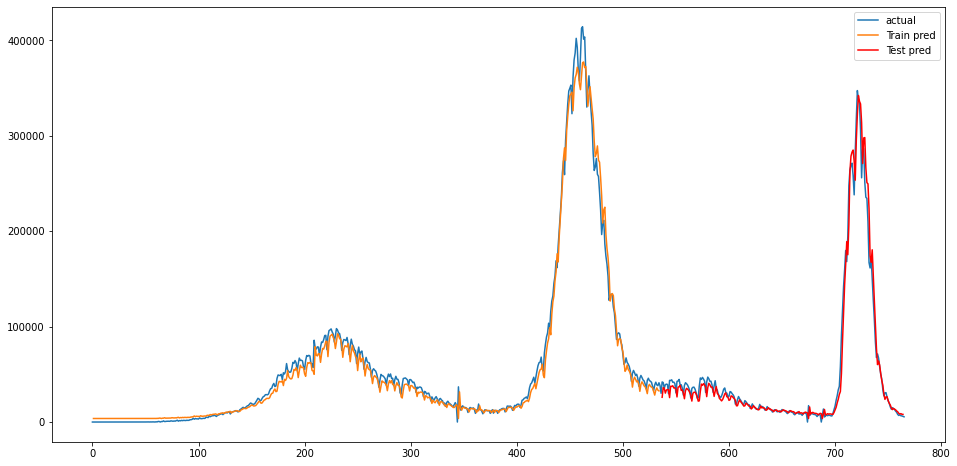

In [41]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(df)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df),label = "actual")
plt.plot(trainPredictPlot, label = "Train pred")
plt.plot(testPredictPlot, label = "Test pred", color ="red")
plt.legend()
plt.show()

In [42]:
print("train score: "+str(r2_score(trainY[0], trainPredict[:,0])))
print("test score: "+str(r2_score(testY[0], testPredict[:,0])))

train score: 0.9873239870639461
test score: 0.9759940208465685


In [43]:
#30 runs
rmse_train_list = []
rmse_test_list = []
r2_train_list = []
r2_test_list = []
for i in range(30):
    model.fit(x_train, y_train, epochs=16, batch_size=1, verbose=0)
    trainPredict = model.predict(x_train,batch_size=1)
    testPredict = model.predict(x_test,batch_size=1)
    # invert predictions
    trainPredict = scaler.inverse_transform(trainPredict)
    testPredict = scaler.inverse_transform(testPredict)
    # calculate root mean squared error
    trainScore = sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
    rmse_train_list.append(trainScore)
    testScore = sqrt(mean_squared_error(testY[0], testPredict[:,0]))
    rmse_test_list.append(testScore)
    r2_train_list.append(r2_score(trainY[0], trainPredict[:,0]))
    r2_test_list.append(r2_score(testY[0], testPredict[:,0]))
    

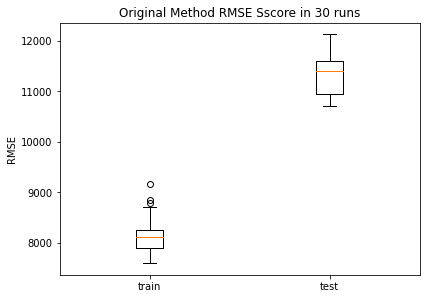

In [61]:

data = [rmse_train_list,rmse_test_list]
fig = plt.figure(figsize =(5, 3.5))
 
# Creating axes instance
ax = fig.add_axes([0,0,1,1])
 
# Creating plot
bp = ax.boxplot(data)
 # x-axis labels
ax.set_xticklabels(['train', 'test'])
plt.ylabel('RMSE')
plt.title("Original Method RMSE Sscore in 30 runs")
# show plot
plt.show()

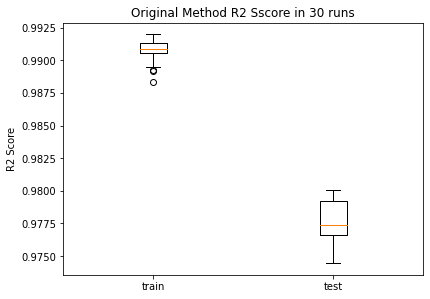

In [62]:
data = [r2_train_list,r2_test_list]
fig = plt.figure(figsize =(5, 3.5))
 
# Creating axes instance
ax = fig.add_axes([0,0,1,1])
 
# Creating plot
bp = ax.boxplot(data)
 # x-axis labels
ax.set_xticklabels(['train', 'test'])
plt.ylabel('R2 Score')
plt.title("Original Method R2 Sscore in 30 runs")
# show plot
plt.show()